In [55]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.svm import SVC 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae 

In [56]:

df = pd.read_csv('train.csv') 

In [57]:
store_sales = df.drop(['store','item'], axis=1)
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [58]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


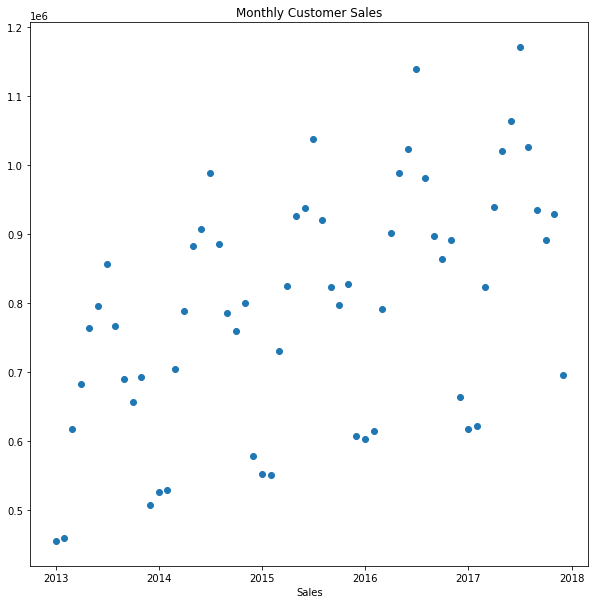

In [59]:
plt.figure(figsize=(10,10))
plt.scatter(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.xlabel('Sales')
plt.title("Monthly Customer Sales")
plt.show()

In [60]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
supverised_data = monthly_sales.drop(['date','sales'], axis=1)

for i in range(1,13):
    col_name = 'month_' + str(i)
    supverised_data[col_name] = supverised_data['sales_diff'].shift(i)
supverised_data = supverised_data.dropna().reset_index(drop=True)
supverised_data.head(10)

train_data = supverised_data[:-12]
test_data = supverised_data[-12:]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()



sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)


In [61]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

MinMaxScaler(feature_range=(-1, 1))

In [62]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_pred = linreg_model.predict(X_test)
linreg_pred = linreg_pred.reshape(-1,1)
linreg_pred_test_set = np.concatenate([linreg_pred,X_test], axis=1)
linreg_pred_test_set = scaler.inverse_transform(linreg_pred_test_set)

In [63]:
act_sales = monthly_sales['sales'][-13:].to_list()

In [64]:
result_list = []
for index in range(0, len(linreg_pred_test_set)):
    result_list.append(linreg_pred_test_set[index][0] + act_sales[index])
linreg_pred_series = pd.Series(result_list,name='linreg_pred')
predict_df = predict_df.merge(linreg_pred_series, left_index=True, right_index=True)

In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [66]:
linreg_rmse = np.sqrt(mean_squared_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:]))
linreg_mae = mean_absolute_error(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
linreg_r2 = r2_score(predict_df['linreg_pred'], monthly_sales['sales'][-12:])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  116719.57703032004
Linear Regression MAE:  95980.2547628299
Linear Regression R2 Score:  0.5377514080121066
